In [14]:
# Import required libraries
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the solar data
BASE_DIR = Path(os.getcwd()).parents[2]  # Get root directory
FILE_PATH = BASE_DIR / "backend/data/Cleaned/Solar_data.csv"
solar_df = pd.read_csv(FILE_PATH)

# Set display options for better readability
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Melt the dataframe to convert months to rows for easier analysis
solar_melted = solar_df.melt(id_vars=['object_name'], 
                                    var_name='month', 
                                    value_name='consumption')

# Missing value analysis
missing_by_building = solar_melted.groupby('object_name')['consumption'].apply(
    lambda x: x.isnull().sum()
).reset_index(name='missing_values')

zero_values_by_building = solar_melted.groupby('object_name')['consumption'].apply(
    lambda x: (x == 0).sum()
).reset_index(name='zero_values')

# Calculate percentage of missing and zero values
total_records = len(solar_melted)
missing_percentage = (solar_melted['consumption'].isnull().sum() / total_records) * 100
zero_percentage = (solar_melted['consumption'] == 0).sum() / total_records * 100

# Calculate descriptive statistics for each building
building_stats = solar_melted.groupby('object_name')['consumption'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.75),
    lambda x: x.skew(),
    lambda x: x.kurtosis()
]).round(2)

building_stats.columns = ['count','mean', 'std', 'min', 'max', 'q25', 'q75', 'skewness', 'kurtosis']

# Additional statistics for non-zero values
non_zero_stats = solar_melted[solar_melted['consumption'] > 0]['consumption'].describe()

# Monthly patterns
monthly_patterns = solar_melted.groupby('month')['consumption'].agg([
    'mean', 'std', 'count'
]).round(2)

# Print results
print("\nMissing Value Analysis:")
print(f"Total Zero Values Percentage: {zero_percentage:.2f}%")

print("\nZero Values by Building:")
print(zero_values_by_building)

print("\nDescriptive Statistics for Individual Buildings:")
print(building_stats)

print("\nNon-Zero Values Statistics:")
print(non_zero_stats)

print("\nMonthly Patterns:")
print(monthly_patterns)

# Calculate total consumption statistics
total_monthly_consumption = solar_melted.groupby('month')['consumption'].sum()

total_stats = {
    'Total Mean Monthly Consumption': total_monthly_consumption.mean(),
    'Total Standard Deviation': total_monthly_consumption.std(),
    'Minimum Total Monthly': total_monthly_consumption.min(),
    'Maximum Total Monthly': total_monthly_consumption.max(),
    'Total Consumption': total_monthly_consumption.sum()
}

print("\nOverall Statistics:")
for stat, value in total_stats.items():
    print(f"{stat}: {value:,.2f}")


Missing Value Analysis:
Total Zero Values Percentage: 14.71%

Zero Values by Building:
                                  object_name  zero_values
0                         E308 Student Health           19
1                F622 Psychology solar energy            0
2          J141 Aquinas Priory solar (Desigo)            1
3  K430 Caroline Freeman College East (Abbey)            0

Descriptive Statistics for Individual Buildings:
                                            count   mean    std    min  \
object_name                                                              
E308 Student Health                            34 101.85 171.61   0.00   
F622 Psychology solar energy                   34 877.68 254.21 438.00   
J141 Aquinas Priory solar (Desigo)             34 902.71 535.24   0.00   
K430 Caroline Freeman College East (Abbey)     34 221.83 210.73  28.00   

                                               max    q25     q75  skewness  \
object_name                                

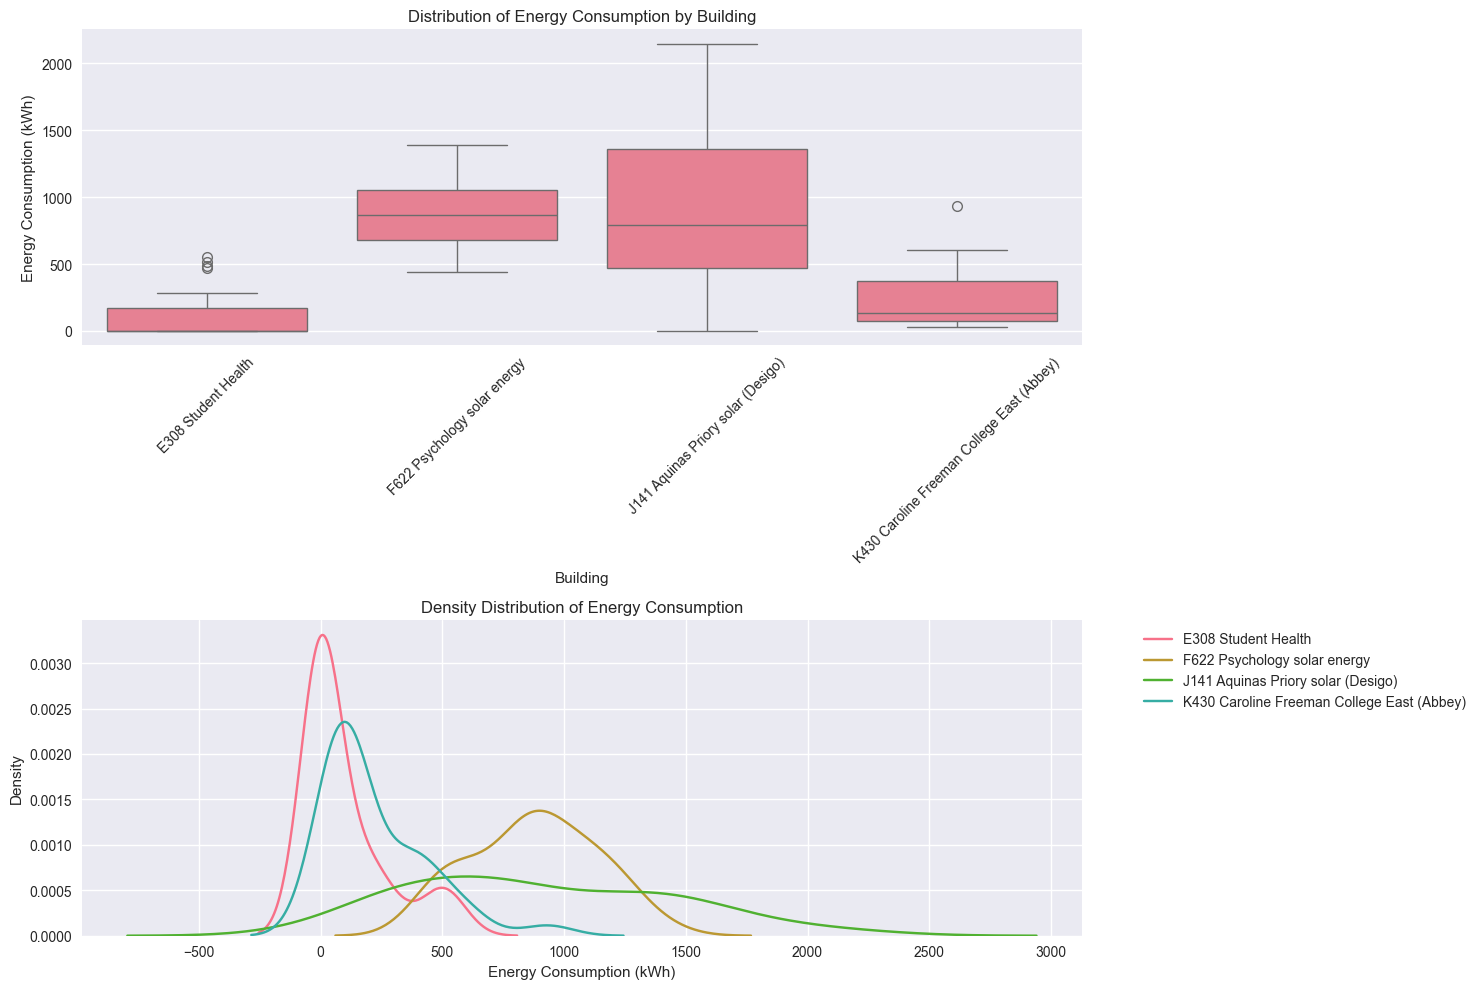


Distribution Statistics:
                                             mean  median    std  skew  \
object_name                                                              
E308 Student Health                        101.85    0.00 171.61  1.56   
F622 Psychology solar energy               877.68  865.50 254.21 -0.03   
J141 Aquinas Priory solar (Desigo)         902.71  792.50 535.24  0.39   
K430 Caroline Freeman College East (Abbey) 221.83  132.75 210.73  1.49   

                                            kurtosis  
object_name                                           
E308 Student Health                             1.10  
F622 Psychology solar energy                   -0.86  
J141 Aquinas Priory solar (Desigo)             -0.73  
K430 Caroline Freeman College East (Abbey)      2.01  


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import kurtosis, skew


solar_melted = solar_df.melt(id_vars=['object_name'], 
                            var_name='month', 
                            value_name='consumption')

# Set style for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 10))

# 1. Distribution Plot
plt.subplot(2, 1, 1)
sns.boxplot(x='object_name', y='consumption', data=solar_melted)
plt.xticks(rotation=45)
plt.title('Distribution of Energy Consumption by Building')
plt.xlabel('Building')
plt.ylabel('Energy Consumption (kWh)')

# 2. Density Plot
plt.subplot(2, 1, 2)
for building in solar_df['object_name'].unique():
    building_data = solar_melted[solar_melted['object_name'] == building]['consumption']
    sns.kdeplot(data=building_data, label=building)
plt.title('Density Distribution of Energy Consumption')
plt.xlabel('Energy Consumption (kWh)')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Calculate distribution statistics
stats_df = solar_melted.groupby('object_name')['consumption'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('skew', lambda x: skew(x, nan_policy='omit')),
    ('kurtosis', lambda x: kurtosis(x, nan_policy='omit'))
]).round(2)

print("\nDistribution Statistics:")
print(stats_df)

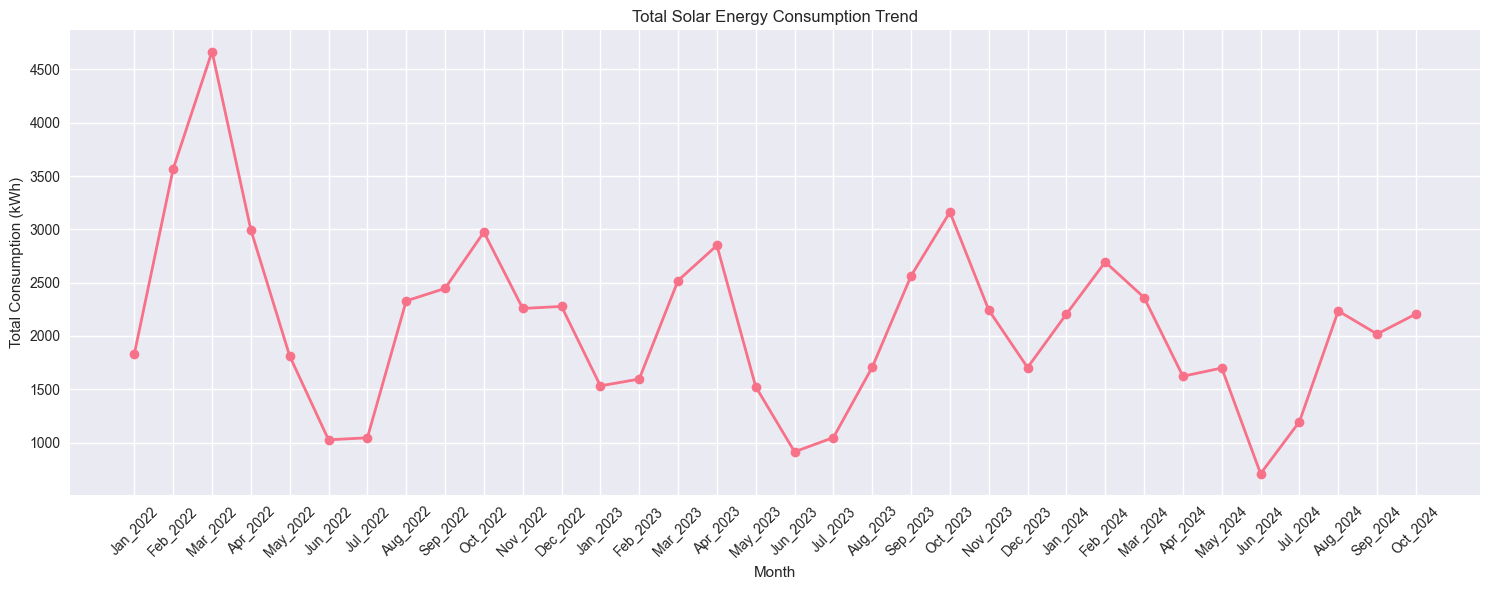

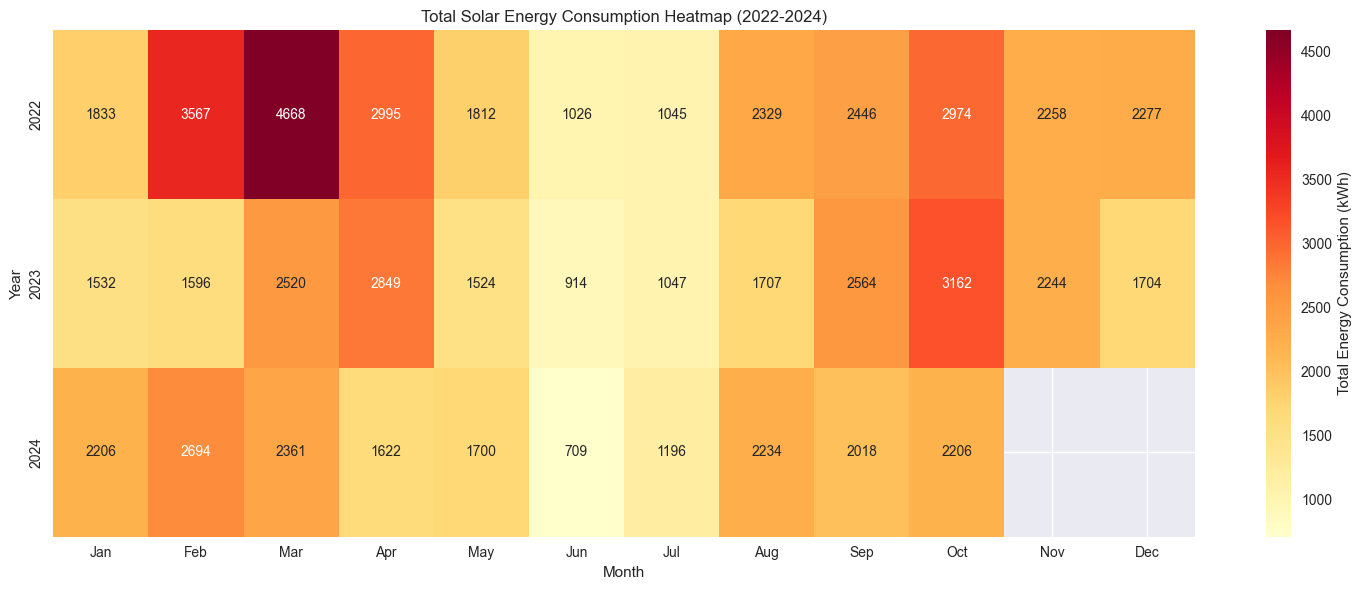

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate total consumption
solar_total = solar_df.set_index('object_name').T
solar_total['Total'] = solar_total.sum(axis=1)

# Create monthly trend plot
plt.figure(figsize=(15, 6))
plt.plot(solar_total.index, solar_total['Total'], marker='o', linewidth=2)
plt.title('Total Solar Energy Consumption Trend')
plt.xlabel('Month')
plt.ylabel('Total Consumption (kWh)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# First, create a list to store the data for each year
yearly_data = []
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for year in [2022, 2023, 2024]:
    year_data = []
    for month in months:
        col_name = f'{month}_{year}'
        if col_name in solar_total.index:
            year_data.append(solar_total.loc[col_name, 'Total'])
        else:
            year_data.append(np.nan)
    yearly_data.append(year_data)

# Convert to DataFrame
heatmap_matrix = pd.DataFrame(yearly_data, 
                            index=[2022, 2023, 2024], 
                            columns=months)

# Create heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(heatmap_matrix, 
            cmap='YlOrRd',
            annot=True,
            fmt='.0f',
            cbar_kws={'label': 'Total Energy Consumption (kWh)'},
            xticklabels=months,
            yticklabels=[2022, 2023, 2024])
plt.title('Total Solar Energy Consumption Heatmap (2022-2024)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

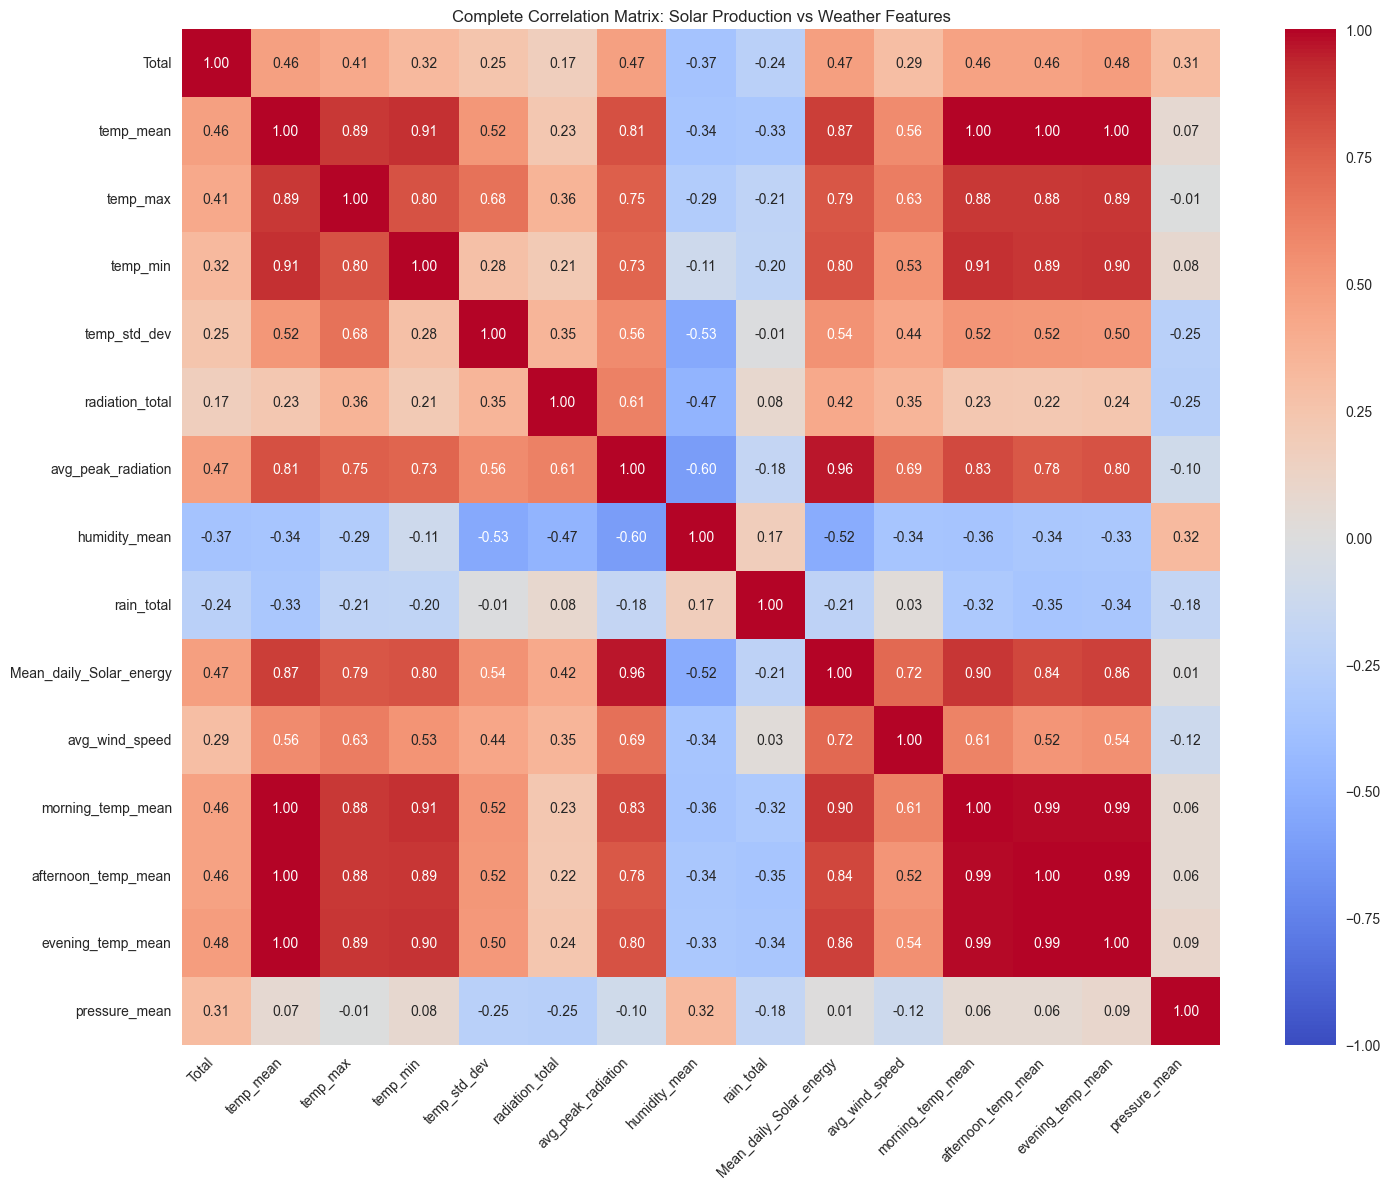


Top Correlations for Each Feature:

Total:
evening_temp_mean         0.48
Mean_daily_Solar_energy   0.47
avg_peak_radiation        0.47
Name: Total, dtype: float64

temp_mean:
afternoon_temp_mean   1.00
morning_temp_mean     1.00
evening_temp_mean     1.00
Name: temp_mean, dtype: float64

temp_max:
evening_temp_mean     0.89
temp_mean             0.89
afternoon_temp_mean   0.88
Name: temp_max, dtype: float64

temp_min:
morning_temp_mean   0.91
temp_mean           0.91
evening_temp_mean   0.90
Name: temp_min, dtype: float64

temp_std_dev:
temp_max                  0.68
avg_peak_radiation        0.56
Mean_daily_Solar_energy   0.54
Name: temp_std_dev, dtype: float64

radiation_total:
avg_peak_radiation        0.61
Mean_daily_Solar_energy   0.42
temp_max                  0.36
Name: radiation_total, dtype: float64

avg_peak_radiation:
Mean_daily_Solar_energy   0.96
morning_temp_mean         0.83
temp_mean                 0.81
Name: avg_peak_radiation, dtype: float64

humidity_mean:
pressur

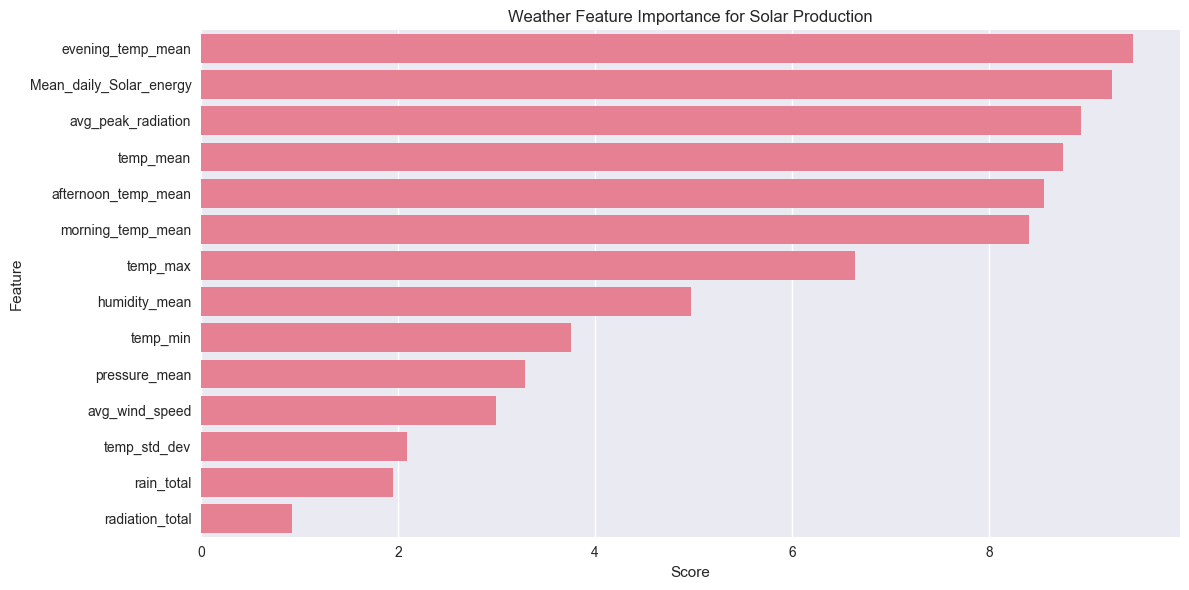


Top Weather Features Correlations with Solar Production:
evening_temp_mean         0.48
Mean_daily_Solar_energy   0.47
avg_peak_radiation        0.47
temp_mean                 0.46
afternoon_temp_mean       0.46
Name: Total, dtype: float64

Top Weather Features by Importance Score:
                    Feature  Score
12        evening_temp_mean   9.47
8   Mean_daily_Solar_energy   9.25
5        avg_peak_radiation   8.93
0                 temp_mean   8.75
11      afternoon_temp_mean   8.56


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression

# Read the data files
FILE_PATH = BASE_DIR / "backend/data/Cleaned/Solar_data.csv"
WEATHER_PATH =BASE_DIR /"backend/data/Weather/Load_weather_monthly.csv"
solar_df = pd.read_csv(FILE_PATH)
weather_df = pd.read_csv(WEATHER_PATH)

# Calculate total solar consumption
solar_total = solar_df.set_index('object_name').T
solar_total['Total'] = solar_total.sum(axis=1)

# Create datetime index for solar data
solar_total.index = pd.to_datetime([f"01-{idx.replace('_', '-')}" for idx in solar_total.index])

# Convert month numbers to datetime in weather_df
weather_df['Date'] = pd.to_datetime(weather_df['Year'].astype(str) + '-' + 
                                  weather_df['Month'].astype(str) + '-01')
weather_df.set_index('Date', inplace=True)

# Select relevant weather features
weather_features = [
    'temp_mean', 'temp_max', 'temp_min', 'temp_std_dev', 
    'radiation_total', 'avg_peak_radiation', 'humidity_mean',
    'rain_total', 'Mean_daily_Solar_energy', 'avg_wind_speed',
    'morning_temp_mean', 'afternoon_temp_mean', 'evening_temp_mean',
    'pressure_mean'
]

# Merge solar and weather data
combined_df = pd.merge(
    solar_total['Total'],
    weather_df[weather_features],
    left_index=True,
    right_index=True,
    how='inner'
)

# Calculate complete correlation matrix
correlation_matrix = combined_df.corr()

# Create correlation heatmap with all features
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            fmt='.2f')
plt.title('Complete Correlation Matrix: Solar Production vs Weather Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print strongest correlations for each feature
print("\nTop Correlations for Each Feature:")
for column in correlation_matrix.columns:
    print(f"\n{column}:")
    # Get top 3 correlations excluding self-correlation
    top_corr = correlation_matrix[column].sort_values(ascending=False)
    top_corr = top_corr[top_corr.index != column][:3]
    print(top_corr)

# Feature importance analysis
X = combined_df[weather_features]
y = combined_df['Total']

# Use SelectKBest to get feature importance scores
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': weather_features,
    'Score': selector.scores_
})
feature_importance = feature_importance.sort_values('Score', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Score', y='Feature', data=feature_importance)
plt.title('Weather Feature Importance for Solar Production')
plt.tight_layout()
plt.show()

# Print top correlations
print("\nTop Weather Features Correlations with Solar Production:")
correlations = correlation_matrix['Total'].sort_values(ascending=False)[1:]
print(correlations.head(5))

# Print top feature importance scores
print("\nTop Weather Features by Importance Score:")
print(feature_importance.head(5))


/var/folders/58/qxt37p251zn90grr221ql66m0000gn/T/ipykernel_8661/925944683.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['season'] = pd.DatetimeIndex(X.index).month.map({12:1, 1:1, 2:1,
/var/folders/58/qxt37p251zn90grr221ql66m0000gn/T/ipykernel_8661/925944683.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['month'] = pd.DatetimeIndex(X.index).month
/var/folders/58/qxt37p251zn90grr221ql66m0000gn/T/ipykernel_8661/925944683.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Linear Regression Results:
Cross-validation R² Score: -8.801 (+/- 34.077)
Test R² Score: -6.663
Test MSE: 2057987.157
Test MAE: 950.514

Ridge Regression Results:
Cross-validation R² Score: -1.571 (+/- 5.480)
Test R² Score: -1.490
Test MSE: 668836.070
Test MAE: 650.647

Lasso Regression Results:
Cross-validation R² Score: -1.360 (+/- 5.331)
Test R² Score: -2.433
Test MSE: 922067.038
Test MAE: 654.795

Random Forest Results:
Cross-validation R² Score: -0.383 (+/- 2.934)
Test R² Score: 0.383
Test MSE: 165737.319
Test MAE: 292.627

Gradient Boosting Results:
Cross-validation R² Score: -0.159 (+/- 1.603)
Test R² Score: -1.101
Test MSE: 564416.023
Test MAE: 604.563


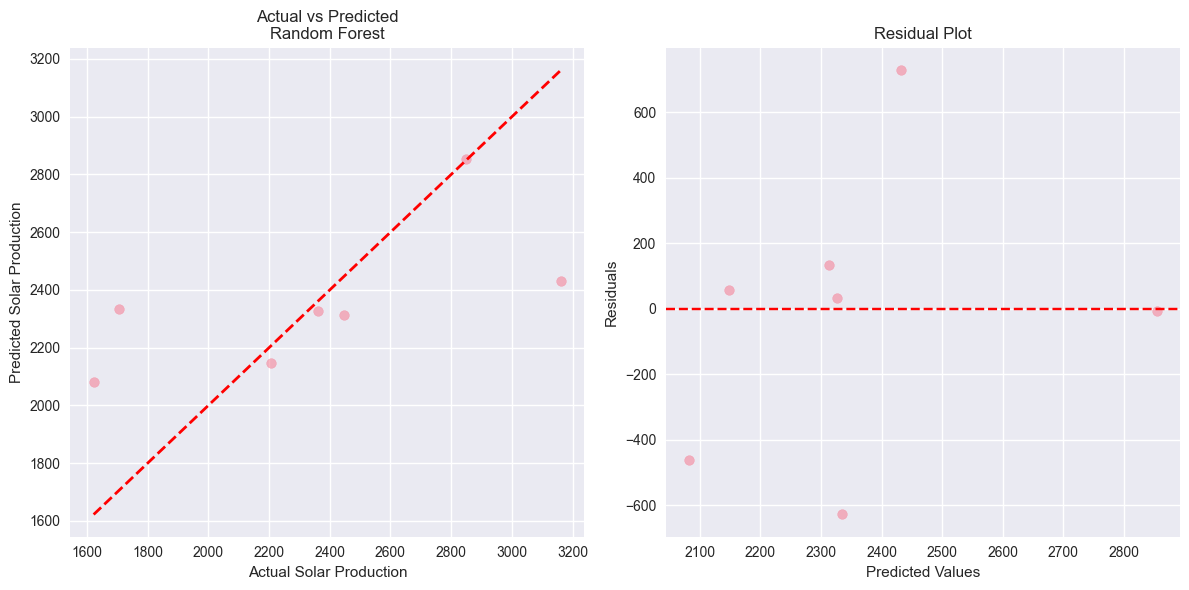

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
solar_total = solar_df.set_index('object_name').T
solar_total['Total'] = solar_total.sum(axis=1)
solar_total.index = pd.to_datetime([f"01-{idx.replace('_', '-')}" for idx in solar_total.index])

weather_df['Date'] = pd.to_datetime(weather_df['Year'].astype(str) + '-' + 
                                  weather_df['Month'].astype(str) + '-01')
weather_df.set_index('Date', inplace=True)

# Select base features
selected_features = ['Mean_daily_Solar_energy', 
                    'avg_peak_radiation', 
                    'humidity_mean',
                    'temp_std_dev']
X = weather_df[selected_features]

# Feature Engineering
X['season'] = pd.DatetimeIndex(X.index).month.map({12:1, 1:1, 2:1, 
                                                  3:2, 4:2, 5:2,
                                                  6:3, 7:3, 8:3, 
                                                  9:4, 10:4, 11:4})
X['month'] = pd.DatetimeIndex(X.index).month
X['radiation_humidity'] = X['Mean_daily_Solar_energy'] * X['humidity_mean']
X['peak_temp'] = X['avg_peak_radiation'] * X['temp_std_dev']

# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
poly_features = poly.get_feature_names_out(X.columns)

# Merge with target
y = solar_total['Total']
data = pd.merge(pd.DataFrame(X_poly, columns=poly_features, index=X.index), 
                y, left_index=True, right_index=True, how='inner')

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[poly_features])
X_scaled = pd.DataFrame(X_scaled, columns=poly_features, index=data.index)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=0.1),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, 
                                                  learning_rate=0.1, 
                                                  max_depth=5, 
                                                  random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate models
for name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, 
                               cv=5, scoring='r2')
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    results[name] = {
        'CV Mean R2': cv_scores.mean(),
        'CV Std R2': cv_scores.std(),
        'Test R2': r2_score(y_test, y_pred),
        'Test MSE': mean_squared_error(y_test, y_pred),
        'Test MAE': mean_absolute_error(y_test, y_pred)
    }

# Print results
for name, metrics in results.items():
    print(f"\n{name} Results:")
    print(f"Cross-validation R² Score: {metrics['CV Mean R2']:.3f} (+/- {metrics['CV Std R2']*2:.3f})")
    print(f"Test R² Score: {metrics['Test R2']:.3f}")
    print(f"Test MSE: {metrics['Test MSE']:.3f}")
    print(f"Test MAE: {metrics['Test MAE']:.3f}")

# Plot actual vs predicted for best model
best_model_name = max(results.items(), key=lambda x: x[1]['Test R2'])[0]
best_model = models[best_model_name]
y_pred = best_model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Solar Production')
plt.ylabel('Predicted Solar Production')
plt.title(f'Actual vs Predicted\n{best_model_name}')

# Plot residuals
plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()


In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

# Prepare initial data
solar_total = solar_df.set_index('object_name').T
solar_total['Total'] = solar_total.sum(axis=1)
solar_total.index = pd.to_datetime([f"01-{idx.replace('_', '-')}" for idx in solar_total.index])

weather_df['Date'] = pd.to_datetime(weather_df['Year'].astype(str) + '-' + 
                                  weather_df['Month'].astype(str) + '-01')
weather_df.set_index('Date', inplace=True)

# Merge data first
merged_df = pd.merge(solar_total['Total'], 
                    weather_df,
                    left_index=True,
                    right_index=True,
                    how='inner')

# Create base features
X = merged_df[['Mean_daily_Solar_energy', 
               'avg_peak_radiation', 
               'humidity_mean', 
               'temp_std_dev'
               ]].copy()

# Add consumption lags (1-3 months)
#X['consumption_lag_1'] = merged_df['Total'].shift(1)
#X['consumption_lag_2'] = merged_df['Total'].shift(2)
#X['consumption_lag_3'] = merged_df['Total'].shift(3)

# Add rolling statistics for consumption
#X['consumption_rolling_mean_3'] = merged_df['Total'].rolling(window=3).mean()
#X['consumption_rolling_std_3'] = merged_df['Total'].rolling(window=3).std()

# Enhanced seasonal features
#X['month'] = X.index.month
#X['quarter'] = X.index.quarter
#X['year'] = X.index.year
X['daylight_hours'] = X['Mean_daily_Solar_energy'] / X['avg_peak_radiation']

# Cyclical encoding
#X['month_sin'] = np.sin(2 * np.pi * X['month']/12)
#X['month_cos'] = np.cos(2 * np.pi * X['month']/12)
#X['quarter_sin'] = np.sin(2 * np.pi * X['quarter']/4)
#X['quarter_cos'] = np.cos(2 * np.pi * X['quarter']/4)

# Weather interaction terms
X['radiation_humidity'] = X['Mean_daily_Solar_energy'] * X['humidity_mean']
X['radiation_temp'] = X['Mean_daily_Solar_energy'] * X['temp_std_dev']
X['peak_humidity'] = X['avg_peak_radiation'] * X['humidity_mean']

# Season-specific features
#X['is_summer'] = X['month'].isin([12, 1, 2]).astype(int)
#X['is_winter'] = X['month'].isin([6, 7, 8]).astype(int)
#X['season_radiation'] = X['Mean_daily_Solar_energy'] * X['is_summer']

X['morning_temp_mean'] = weather_df['morning_temp_mean']
X['evening_temp_mean'] = weather_df['evening_temp_mean']
X['afternoon_temp_mean'] = weather_df['afternoon_temp_mean']


# Add pressure and wind features
X['pressure_mean'] = weather_df['pressure_mean']
X['avg_wind_speed'] = weather_df['avg_wind_speed']

# Add seasonal weights based on search results
season_weights = {
    12: 0.40, 1: 0.40, 2: 0.40,  # Summer
    3: 0.35, 4: 0.35, 5: 0.35,   # Autumn
    6: 0.45, 7: 0.45, 8: 0.45,   # Winter
    9: 0.30, 10: 0.30, 11: 0.30  # Spring
}
X['seasonal_weight'] = X.index.month.map(season_weights)

# Add weather lags
'''
for feature in ['Mean_daily_Solar_energy', 'avg_peak_radiation', 'humidity_mean']:
    X[f'{feature}_lag_1'] = merged_df[feature].shift(1)
    X[f'{feature}_rolling_mean_3'] = merged_df[feature].rolling(window=3).mean()
    X[f'{feature}_rolling_std_3'] = merged_df[feature].rolling(window=3).std()
'''
# Drop NaN values from lag features
#X = X.dropna()
X = X.fillna(method='ffill').fillna(method='bfill')
y = merged_df['Total'][X.index]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Define parameter grid for RandomForest
param_grid = {
    #'n_estimators': [30, 50, 100],
    #'max_depth': [3, 5,10, 15, 20],
    #'min_samples_split': [1,2,3,4,5],
    #'min_samples_leaf': [1, 2]

    'n_estimators': [50, 100, 200],
    'max_depth': [5, 8, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4]
}

# Add feature selection step here
selector = SelectFromModel(RandomForestRegressor(random_state=42))
X_selected = selector.fit_transform(X_scaled, y)
X_selected = pd.DataFrame(X_selected, columns=X_scaled.columns[selector.get_support()])

# Then proceed with train-test split using selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Grid search with cross-validation
rf = RandomForestRegressor(random_state=42)
#grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2')
#grid_search.fit(X_train, y_train)

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(rf, param_grid, cv=tscv, scoring='r2', error_score='raise')

grid_search.fit(X_train, y_train) 

# Get best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# After model fitting, calculate scores for both training and test sets
train_pred = best_rf.predict(X_train)
test_pred = best_rf.predict(X_test)

# Calculate metrics for both sets
train_scores = {
    'R² Score': r2_score(y_train, train_pred),
    'MSE': mean_squared_error(y_train, train_pred),
    'MAE': mean_absolute_error(y_train, train_pred)
}

test_scores = {
    'R² Score': r2_score(y_test, test_pred),
    'MSE': mean_squared_error(y_test, test_pred),
    'MAE': mean_absolute_error(y_test, test_pred)
}

# Print results
print("\nTraining Set Performance:")
for metric, value in train_scores.items():
    print(f"{metric}: {value:.3f}")

print("\nTest Set Performance:")
for metric, value in test_scores.items():
    print(f"{metric}: {value:.3f}")

# Print results
print("Best Parameters:", grid_search.best_params_)
print("\nModel Performance:")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

# Feature importance should use selected features
feature_importance = pd.DataFrame({
    'feature': X_scaled.columns[selector.get_support()],
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop Selected Features and their Importance:")
print(feature_importance)


/var/folders/58/qxt37p251zn90grr221ql66m0000gn/T/ipykernel_8661/1628372157.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')



Training Set Performance:
R² Score: 0.892
MSE: 79921.191
MAE: 175.823

Test Set Performance:
R² Score: 0.317
MSE: 183325.929
MAE: 339.590
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

Model Performance:
R² Score: 0.317
MSE: 183325.929
MAE: 339.590

Top Selected Features and their Importance:
                   feature  importance
0  Mean_daily_Solar_energy        0.40
3            pressure_mean        0.26
1           daylight_hours        0.22
2           radiation_temp        0.12


In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

# Prepare initial data
solar_total = solar_df.set_index('object_name').T
solar_total['Total'] = solar_total.sum(axis=1)
solar_total.index = pd.to_datetime([f"01-{idx.replace('_', '-')}" for idx in solar_total.index])

weather_df['Date'] = pd.to_datetime(weather_df['Year'].astype(str) + '-' + 
                                  weather_df['Month'].astype(str) + '-01')
weather_df.set_index('Date', inplace=True)

# Merge data first
merged_df = pd.merge(solar_total['Total'], 
                    weather_df,
                    left_index=True,
                    right_index=True,
                    how='inner')

# Create base features
X = merged_df[['Mean_daily_Solar_energy', 
               'avg_peak_radiation', 
               'humidity_mean', 
               'temp_std_dev'
               ]].copy()

# Add consumption lags (1-3 months)
#X['consumption_lag_1'] = merged_df['Total'].shift(1)
#X['consumption_lag_2'] = merged_df['Total'].shift(2)
#X['consumption_lag_3'] = merged_df['Total'].shift(3)

# Add rolling statistics for consumption
#X['consumption_rolling_mean_3'] = merged_df['Total'].rolling(window=3).mean()
#X['consumption_rolling_std_3'] = merged_df['Total'].rolling(window=3).std()

# Enhanced seasonal features
#X['month'] = X.index.month
#X['quarter'] = X.index.quarter
#X['year'] = X.index.year
X['daylight_hours'] = X['Mean_daily_Solar_energy'] / X['avg_peak_radiation']

# Cyclical encoding
#X['month_sin'] = np.sin(2 * np.pi * X['month']/12)
#X['month_cos'] = np.cos(2 * np.pi * X['month']/12)
#X['quarter_sin'] = np.sin(2 * np.pi * X['quarter']/4)
#X['quarter_cos'] = np.cos(2 * np.pi * X['quarter']/4)

# Weather interaction terms
X['radiation_humidity'] = X['Mean_daily_Solar_energy'] * X['humidity_mean']
X['radiation_temp'] = X['Mean_daily_Solar_energy'] * X['temp_std_dev']
X['peak_humidity'] = X['avg_peak_radiation'] * X['humidity_mean']

# Season-specific features
#X['is_summer'] = X['month'].isin([12, 1, 2]).astype(int)
#X['is_winter'] = X['month'].isin([6, 7, 8]).astype(int)
#X['season_radiation'] = X['Mean_daily_Solar_energy'] * X['is_summer']

X['morning_temp_mean'] = weather_df['morning_temp_mean']
X['evening_temp_mean'] = weather_df['evening_temp_mean']
X['afternoon_temp_mean'] = weather_df['afternoon_temp_mean']


# Add pressure and wind features
X['pressure_mean'] = weather_df['pressure_mean']
X['avg_wind_speed'] = weather_df['avg_wind_speed']

# Add seasonal weights based on search results
season_weights = {
    12: 0.40, 1: 0.40, 2: 0.40,  # Summer
    3: 0.35, 4: 0.35, 5: 0.35,   # Autumn
    6: 0.45, 7: 0.45, 8: 0.45,   # Winter
    9: 0.30, 10: 0.30, 11: 0.30  # Spring
}
X['seasonal_weight'] = X.index.month.map(season_weights)

# Add weather lags
'''
for feature in ['Mean_daily_Solar_energy', 'avg_peak_radiation', 'humidity_mean']:
    X[f'{feature}_lag_1'] = merged_df[feature].shift(1)
    X[f'{feature}_rolling_mean_3'] = merged_df[feature].rolling(window=3).mean()
    X[f'{feature}_rolling_std_3'] = merged_df[feature].rolling(window=3).std()
'''

for feature in ['Mean_daily_Solar_energy']:
    X[f'{feature}_lag_1'] = merged_df[feature].shift(1)
    X[f'{feature}_rolling_mean_3'] = merged_df[feature].rolling(window=3).mean()
    X[f'{feature}_rolling_std_3'] = merged_df[feature].rolling(window=3).std()


# Drop NaN values from lag features
#X = X.dropna()
X = X.fillna(method='ffill').fillna(method='bfill')
y = merged_df['Total'][X.index]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Define parameter grid for RandomForest
param_grid = {
    #'n_estimators': [30, 50, 100],
    #'max_depth': [3, 5,10, 15, 20],
    #'min_samples_split': [1,2,3,4,5],
    #'min_samples_leaf': [1, 2]

    'n_estimators': [50, 100, 200],
    'max_depth': [5, 8, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4]
}

# Add feature selection step here
selector = SelectFromModel(RandomForestRegressor(random_state=42))
X_selected = selector.fit_transform(X_scaled, y)
X_selected = pd.DataFrame(X_selected, columns=X_scaled.columns[selector.get_support()])

# Then proceed with train-test split using selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Grid search with cross-validation
rf = RandomForestRegressor(random_state=42)
#grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2')
#grid_search.fit(X_train, y_train)

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(rf, param_grid, cv=tscv, scoring='r2', error_score='raise')

grid_search.fit(X_train, y_train) 

# Get best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# After model fitting, calculate scores for both training and test sets
train_pred = best_rf.predict(X_train)
test_pred = best_rf.predict(X_test)

# Calculate metrics for both sets
train_scores = {
    'R² Score': r2_score(y_train, train_pred),
    'MSE': mean_squared_error(y_train, train_pred),
    'MAE': mean_absolute_error(y_train, train_pred)
}

test_scores = {
    'R² Score': r2_score(y_test, test_pred),
    'MSE': mean_squared_error(y_test, test_pred),
    'MAE': mean_absolute_error(y_test, test_pred)
}

# Print results
print("\nTraining Set Performance:")
for metric, value in train_scores.items():
    print(f"{metric}: {value:.3f}")

print("\nTest Set Performance:")
for metric, value in test_scores.items():
    print(f"{metric}: {value:.3f}")

# Print results
print("Best Parameters:", grid_search.best_params_)
print("\nModel Performance:")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

# Feature importance should use selected features
feature_importance = pd.DataFrame({
    'feature': X_scaled.columns[selector.get_support()],
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop Selected Features and their Importance:")
print(feature_importance)


/var/folders/58/qxt37p251zn90grr221ql66m0000gn/T/ipykernel_8661/1162697285.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')



Training Set Performance:
R² Score: 0.892
MSE: 79921.191
MAE: 175.823

Test Set Performance:
R² Score: 0.317
MSE: 183325.929
MAE: 339.590
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

Model Performance:
R² Score: 0.317
MSE: 183325.929
MAE: 339.590

Top Selected Features and their Importance:
                   feature  importance
0  Mean_daily_Solar_energy        0.40
3            pressure_mean        0.26
1           daylight_hours        0.22
2           radiation_temp        0.12
